In [130]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib.cbook import boxplot_stats
import seaborn as sns
import json
import psycopg2
from sklearn.preprocessing import StandardScaler
import pycountry_convert as pc

In [27]:

# Load all credentials 
with open(rf'C:\Users\gurpr\OneDrive\Documents\New Projects\Weather and Pollution\Data_ETL\config.json') as config_file:
    config = json.load(config_file)

db_name = config['db_name']
db_user = config['user']
db_pass = config['password']
db_host = 'localhost'
db_port = config['port']

# Connect to the PostgreSQL database
conn = psycopg2.connect(dbname=db_name, user=db_user, password=db_pass, host=db_host, port=db_port)
cursor = conn.cursor()


def sql_to_dataframe(conn, query):
   '''
   Import data from a PostgreSQL database using a SELECT query 
   '''
   cursor = conn.cursor()
   cursor.execute(query)
   tuples_list = cursor.fetchall()
   cursor.close()
   column_names = [desc[0] for desc in cursor.description]
   df = pd.DataFrame(tuples_list, columns= column_names)
   
   return df

# Load all the data from the tables
cities_query = 'SELECT * FROM cities'
Cities_df = sql_to_dataframe(conn , cities_query)

weather_query = 'SELECT * FROM weather'
Weather_df = sql_to_dataframe(conn , weather_query)

pollution_query = 'SELECT * FROM pollution'
Pollution_df = sql_to_dataframe(conn , pollution_query)


#Change resolution of date_time to hour
Weather_df['date_time_hour'] = Weather_df['date_time'].dt.ceil(freq='h')  
Pollution_df['date_time_hour'] = Pollution_df['date_time'].dt.ceil(freq='h')  

#Merge dfs
merged_df = Weather_df.merge(Pollution_df, how='inner', left_on=['city_id', 'date_time_hour'], right_on=['city_id', 'date_time_hour'])

Exploratory Data Analysis 

In [30]:
#Check for Null values in important columns and drop those rows
merged_df.info()
merged_df.dropna(subset=['temperature','pm2_5','pm10','temp_min','temp_max'],inplace = True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1092 entries, 1 to 1199
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   weather_id           1092 non-null   int64         
 1   city_id              1092 non-null   int64         
 2   date_time_x          1092 non-null   datetime64[ns]
 3   local_time_x         1092 non-null   datetime64[ns]
 4   temperature          1092 non-null   float64       
 5   feels_like           1081 non-null   float64       
 6   temp_min             1092 non-null   float64       
 7   temp_max             1092 non-null   float64       
 8   pressure             1092 non-null   int64         
 9   humidity             1092 non-null   int64         
 10  visibility           1092 non-null   int64         
 11  wind_speed           1004 non-null   float64       
 12  wind_deg             1092 non-null   int64         
 13  clouds_all           1092 non-null   i

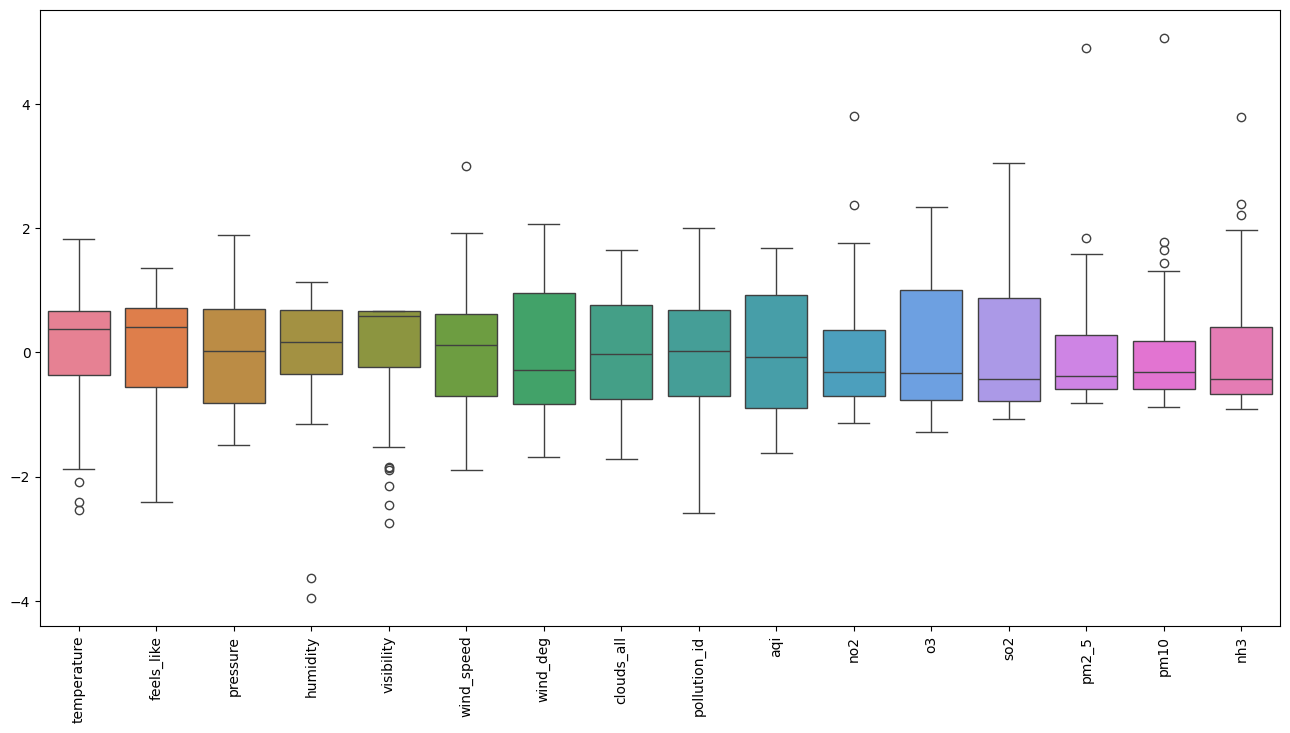

In [109]:
numerical_df = merged_df.select_dtypes('number')
numerical_df.drop(columns=['weather_id','temp_min','temp_max','no','co'],inplace=True)
numerical_df_by_city = numerical_df.groupby('city_id').mean()
scaler = StandardScaler()
numerical_df_by_city[numerical_df_by_city.columns]=scaler.fit_transform(numerical_df_by_city[numerical_df_by_city.columns])

fig, axes = plt.subplots(figsize=(16,8))
sns.boxplot(ax = axes, data= numerical_df_by_city)
axes.tick_params(axis='x', labelrotation=90)

# Outlier detection

outliers_dict = {
    col: [y for stat in boxplot_stats(numerical_df_by_city[col]) for y in stat['fliers']]
    for col in numerical_df_by_city.columns}


outlier_indices = set()

# Loop through each column and collect the index values of the outlier rows
for col, outliers in outliers_dict.items():
    if outliers:  # If there are outliers in the column
        outlier_indices.update(numerical_df_by_city[numerical_df_by_city[col].isin(outliers)].index)

# Convert the set to a list and assign a name to the index
outlier_indices = list(outlier_indices)
outlier_indices = pd.Index(outlier_indices, name='city_id')


Going forward, I will seperate the dataset into 2. One will only contain the data about the outlier cities and other will have them removed. The cities will also have a label depending on their continient and will also be grouped depeding on their population to allow different methods of analysing the data.

In [248]:
# Define the population ranges (bins) and corresponding labels (bands) and use pd.cut to create the population_band column
bins = [1000000, 5000000, 10000000, 15000000, 20000000, 25000000, 30000000, 35000000, 400000000]
labels = [1, 2, 3, 4, 5, 6, 7, 8]
Cities_df['population_band'] = pd.cut(Cities_df['population'], bins=bins, labels=labels, right=False)

def get_continent_code(country_code):
        return pc.country_alpha2_to_continent_code(country_code)

Cities_df['continent'] = Cities_df['country'].apply(get_continent_code)


#Assign a categorical value for continets for groupby 
continent_mapping = {'AF': 1, 'AS': 2,  'EU': 3,   'NA': 4,  'SA': 5  }
Cities_df['continent_num'] = Cities_df['continent'].map(continent_mapping)
Cities_df['continent_num'] = Cities_df['continent_num'].astype('category')



In [259]:

new_merged_df = numerical_df.merge(Cities_df, how='inner', left_on=['city_id'], right_on=['city_id'])

#Create two new dateframes 
df_outliers = new_merged_df[new_merged_df['city_id'].isin(outlier_indices)]
df_wo_outliers = new_merged_df[~new_merged_df['city_id'].isin(outlier_indices)]

#Count function for plotting values on barchart
outlier_pop_count = df_outliers.groupby('population_band')['city_id'].nunique().to_dict()
outlier_con_count = df_outliers.groupby('continent_num')['city_id'].nunique().to_dict()
no_outlier_pop_count = df_wo_outliers.groupby('population_band')['city_id'].nunique().to_dict()
no_outlier_con_count = df_wo_outliers.groupby('continent_num')['city_id'].nunique().to_dict()

#groupby population bands 
df_outliers_gb_band = df_outliers.select_dtypes(exclude=['object','datetime','bool'])
df_outliers_gb_band = df_outliers_gb_band.drop(columns = 'continent_num')
df_outliers_gb_band = df_outliers_gb_band.groupby('population_band',observed=False ).mean().reset_index()


df_wo_outliers_gb_band = df_wo_outliers.select_dtypes(exclude=['object','datetime','bool'])
df_wo_outliers_gb_band = df_wo_outliers_gb_band.drop(columns = ['continent_num'])
df_wo_outliers_gb_band = df_wo_outliers_gb_band.groupby('population_band',observed=False ).mean().reset_index()

#Groupby Continets
df_outliers_gb_continent = df_outliers.select_dtypes(exclude=['object','datetime','bool'])
df_outliers_gb_continent = df_outliers_gb_continent.drop(columns = ['population_band'])
df_outliers_gb_continent = df_outliers_gb_continent.groupby('continent_num',observed=False).mean().reset_index()


df_wo_outliers_gb_continent = df_wo_outliers.select_dtypes(exclude=['object','datetime','bool'])
df_wo_outliers_gb_continent = df_wo_outliers_gb_continent.drop(columns = ['population_band'])
df_wo_outliers_gb_continent = df_wo_outliers_gb_continent.groupby('continent_num',observed=False).mean().reset_index()



C:\Users\gurpr\AppData\Local\Temp\ipykernel_16544\966827250.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outlier_pop_count = df_outliers.groupby('population_band')['city_id'].nunique().to_dict()
C:\Users\gurpr\AppData\Local\Temp\ipykernel_16544\966827250.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outlier_con_count = df_outliers.groupby('continent_num')['city_id'].nunique().to_dict()
C:\Users\gurpr\AppData\Local\Temp\ipykernel_16544\966827250.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain

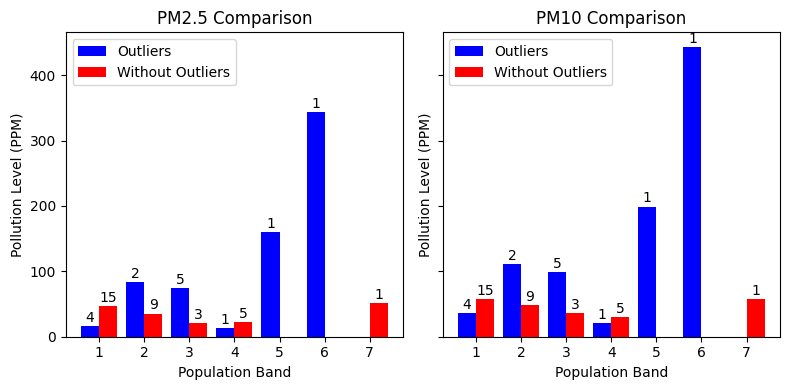

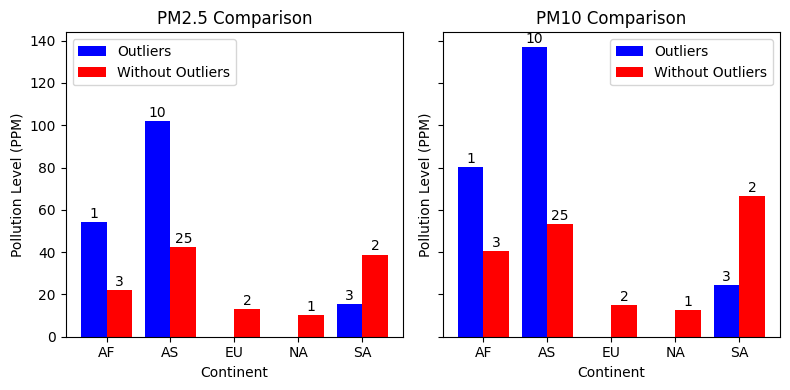

In [260]:

# Population Bands Plot
fig1, ax1 = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)

x1 = df_outliers_gb_band['population_band']
y1 = df_outliers_gb_band['pm2_5']
y2 = df_wo_outliers_gb_band['pm2_5']
y3 = df_outliers_gb_band['pm10']
y4 = df_wo_outliers_gb_band['pm10']

X_axis = np.arange(len(x1.unique()))  
width = 0.4  

# Plot PM2.5
bars1 = ax1[0].bar(X_axis - width/2, y1, width=width, label='Outliers', color='b')
bars2 = ax1[0].bar(X_axis + width/2, y2, width=width, label='Without Outliers', color='r')
ax1[0].set_title('PM2.5 Comparison')
ax1[0].set_xlabel('Population Band')
ax1[0].set_ylabel('Pollution Level (PPM)')
ax1[0].legend()

# Annotate PM2.5 bars
for i, bar in enumerate(bars1):
    population_band = x1.unique()[i]
    count = outlier_pop_count.get(population_band, 0)
    ax1[0].annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

for i, bar in enumerate(bars2):
    population_band = x1.unique()[i]
    count = no_outlier_pop_count.get(population_band, 0)
    ax1[0].annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

# Plot PM10
bars3 = ax1[1].bar(X_axis - width/2, y3, width=width, label='Outliers', color='b')
bars4 = ax1[1].bar(X_axis + width/2, y4, width=width, label='Without Outliers', color='r')
ax1[1].set_title('PM10 Comparison')
ax1[1].set_xlabel('Population Band')
ax1[1].set_ylabel('Pollution Level (PPM)')
ax1[1].legend()

# Annotate PM10 bars
for i, bar in enumerate(bars3):
    population_band = x1.unique()[i]
    count = outlier_pop_count.get(population_band, 0)
    ax1[1].annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

for i, bar in enumerate(bars4):
    population_band = x1.unique()[i]
    count = no_outlier_pop_count.get(population_band, 0)
    ax1[1].annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

plt.tight_layout()

# Continent Comparison Plot
fig2, ax2 = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)

# Define continent mapping
continent_mapping = {1: 'AF', 2: 'AS', 3: 'EU', 4: 'NA', 5: 'SA'}
x2_labels = [continent_mapping[num] for num in sorted(continent_mapping.keys())]

y5 = df_outliers_gb_continent['pm2_5']
y6 = df_wo_outliers_gb_continent['pm2_5']
y7 = df_outliers_gb_continent['pm10']
y8 = df_wo_outliers_gb_continent['pm10']

X_axis_2 = np.arange(len(x2_labels))
width = 0.4  

# Plot PM2.5 for continents
bars5 = ax2[0].bar(X_axis_2 - width/2, y5, width=width, label='Outliers', color='b')
bars6 = ax2[0].bar(X_axis_2 + width/2, y6, width=width, label='Without Outliers', color='r')
ax2[0].set_title('PM2.5 Comparison')
ax2[0].set_xlabel('Continent')
ax2[0].set_ylabel('Pollution Level (PPM)')
ax2[0].set_xticks(X_axis_2)
ax2[0].set_xticklabels(x2_labels)
ax2[0].legend()

# Annotate PM2.5 bars
for i, bar in enumerate(bars5):
    continent_num = sorted(continent_mapping.keys())[i]
    count = outlier_con_count.get(continent_num, 0)
    ax2[0].annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

for i, bar in enumerate(bars6):
    continent_num = sorted(continent_mapping.keys())[i]
    count = no_outlier_con_count.get(continent_num, 0)
    ax2[0].annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

# Plot PM10 for continents
bars7 = ax2[1].bar(X_axis_2 - width/2, y7, width=width, label='Outliers', color='b')
bars8 = ax2[1].bar(X_axis_2 + width/2, y8, width=width, label='Without Outliers', color='r')
ax2[1].set_title('PM10 Comparison')
ax2[1].set_xlabel('Continent')
ax2[1].set_ylabel('Pollution Level (PPM)')
ax2[1].set_xticks(X_axis_2)
ax2[1].set_xticklabels(x2_labels)
ax2[1].legend()

# Annotate PM10 bars
for i, bar in enumerate(bars7):
    continent_num = sorted(continent_mapping.keys())[i]
    count = outlier_con_count.get(continent_num, 0)
    ax2[1].annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

for i, bar in enumerate(bars8):
    continent_num = sorted(continent_mapping.keys())[i]
    count = no_outlier_con_count.get(continent_num, 0)
    ax2[1].annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

plt.tight_layout()
plt.show()
